In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')



In [3]:
# Load the data
print("Loading data...")
tsla = pd.read_csv(r'C:\Users\Antifragile\Desktop\Time_series_stock_analysis\data\TSLA_data.csv', index_col=0, parse_dates=True)
bnd = pd.read_csv(r'C:\Users\Antifragile\Desktop\Time_series_stock_analysis\data\BND_data.csv', index_col=0, parse_dates=True)
spy = pd.read_csv(r'C:\Users\Antifragile\Desktop\Time_series_stock_analysis\data\SPY_data.csv', index_col=0, parse_dates=True)

# Calculate returns if not already present
for name, data in [('TSLA', tsla), ('BND', bnd), ('SPY', spy)]:
    if 'Daily_Return' not in data.columns:
        data['Daily_Return'] = data['Close'].pct_change()

assets = {'TSLA': tsla, 'BND': bnd, 'SPY': spy}
print("Data loaded successfully!")

Loading data...
Data loaded successfully!


In [4]:

print("\n=== VALUE AT RISK (VaR) ANALYSIS ===")

def calculate_var(returns, confidence_level=0.05):
    """
    Calculate Value at Risk using historical simulation
    
    Args:
        returns: Series of daily returns
        confidence_level: Confidence level (0.05 = 5% VaR)
    
    Returns:
        VaR value as a positive number
    """
    if len(returns.dropna()) == 0:
        return np.nan
    
    return -np.percentile(returns.dropna(), confidence_level * 100)

# Calculate VaR for each asset
var_results = {}

for ticker, data in assets.items():
    returns = data['Daily_Return'].dropna()
    
    # Daily VaR at 5% confidence level
    daily_var_5 = calculate_var(returns, 0.05)
    daily_var_1 = calculate_var(returns, 0.01)
    
    # Annualized VaR (assuming 252 trading days)
    annual_var_5 = daily_var_5 * np.sqrt(252)
    annual_var_1 = daily_var_1 * np.sqrt(252)
    
    var_results[ticker] = {
        'Daily_VaR_5%': daily_var_5,
        'Daily_VaR_1%': daily_var_1,
        'Annual_VaR_5%': annual_var_5,
        'Annual_VaR_1%': annual_var_1
    }
    
    print(f"{ticker} Value at Risk:")
    print(f"  Daily VaR (5%): {daily_var_5*100:.2f}%")
    print(f"  Daily VaR (1%): {daily_var_1*100:.2f}%")
    print(f"  Annual VaR (5%): {annual_var_5*100:.2f}%")
    print(f"  Annual VaR (1%): {annual_var_1*100:.2f}%")
    print()



=== VALUE AT RISK (VaR) ANALYSIS ===
TSLA Value at Risk:
  Daily VaR (5%): 5.47%
  Daily VaR (1%): 9.27%
  Annual VaR (5%): 86.77%
  Annual VaR (1%): 147.21%

BND Value at Risk:
  Daily VaR (5%): 0.49%
  Daily VaR (1%): 0.88%
  Annual VaR (5%): 7.78%
  Annual VaR (1%): 13.95%

SPY Value at Risk:
  Daily VaR (5%): 1.72%
  Daily VaR (1%): 3.31%
  Annual VaR (5%): 27.30%
  Annual VaR (1%): 52.61%



In [5]:
print("=== CONDITIONAL VALUE AT RISK (CVaR) ===")

def calculate_cvar(returns, confidence_level=0.05):
    """Calculate Conditional Value at Risk (Expected Shortfall)"""
    if len(returns.dropna()) == 0:
        return np.nan
    
    var_threshold = np.percentile(returns.dropna(), confidence_level * 100)
    return -returns[returns <= var_threshold].mean()

for ticker, data in assets.items():
    returns = data['Daily_Return'].dropna()
    
    daily_cvar_5 = calculate_cvar(returns, 0.05)
    annual_cvar_5 = daily_cvar_5 * np.sqrt(252)
    
    print(f"{ticker} Conditional VaR (5%):")
    print(f"  Daily CVaR: {daily_cvar_5*100:.2f}%")
    print(f"  Annual CVaR: {annual_cvar_5*100:.2f}%")

=== CONDITIONAL VALUE AT RISK (CVaR) ===
TSLA Conditional VaR (5%):
  Daily CVaR: 8.20%
  Annual CVaR: 130.11%
BND Conditional VaR (5%):
  Daily CVaR: 0.77%
  Annual CVaR: 12.28%
SPY Conditional VaR (5%):
  Daily CVaR: 2.80%
  Annual CVaR: 44.46%


In [6]:

print("\n=== SHARPE RATIO ANALYSIS ===")

# Risk-free rate (assuming 3% annual)
risk_free_rate = 0.03
daily_risk_free = risk_free_rate / 252

def calculate_sharpe_ratio(returns, risk_free_rate=daily_risk_free):
    """Calculate Sharpe Ratio"""
    if len(returns.dropna()) == 0:
        return np.nan
    
    excess_returns = returns.dropna() - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

sharpe_results = {}

for ticker, data in assets.items():
    returns = data['Daily_Return'].dropna()
    
    # Daily Sharpe ratio
    daily_sharpe = calculate_sharpe_ratio(returns)
    
    # Annualized Sharpe ratio
    annual_sharpe = daily_sharpe * np.sqrt(252)
    
    # Additional metrics
    annual_return = returns.mean() * 252
    annual_volatility = returns.std() * np.sqrt(252)
    
    sharpe_results[ticker] = {
        'Annual_Return': annual_return,
        'Annual_Volatility': annual_volatility,
        'Sharpe_Ratio': annual_sharpe
    }
    
    print(f"{ticker} Performance Metrics:")
    print(f"  Annual Return: {annual_return*100:.2f}%")
    print(f"  Annual Volatility: {annual_volatility*100:.2f}%")
    print(f"  Sharpe Ratio: {annual_sharpe:.3f}")
    print()


=== SHARPE RATIO ANALYSIS ===
TSLA Performance Metrics:
  Annual Return: 46.07%
  Annual Volatility: 59.19%
  Sharpe Ratio: 0.728

BND Performance Metrics:
  Annual Return: 1.96%
  Annual Volatility: 5.49%
  Sharpe Ratio: -0.189

SPY Performance Metrics:
  Annual Return: 14.48%
  Annual Volatility: 18.24%
  Sharpe Ratio: 0.630



In [7]:
print("=== MAXIMUM DRAWDOWN ANALYSIS ===")

def calculate_max_drawdown(prices):
    """Calculate maximum drawdown"""
    # Calculate cumulative returns
    cumulative = (1 + prices.pct_change().fillna(0)).cumprod()
    
    # Calculate running maximum
    running_max = cumulative.expanding().max()
    
    # Calculate drawdown
    drawdown = (cumulative - running_max) / running_max
    
    return drawdown.min()

for ticker, data in assets.items():
    max_dd = calculate_max_drawdown(data['Close'])
    
    print(f"{ticker} Maximum Drawdown: {max_dd*100:.2f}%")

=== MAXIMUM DRAWDOWN ANALYSIS ===
TSLA Maximum Drawdown: -73.63%
BND Maximum Drawdown: -18.58%
SPY Maximum Drawdown: -33.72%



=== RISK-RETURN VISUALIZATION ===


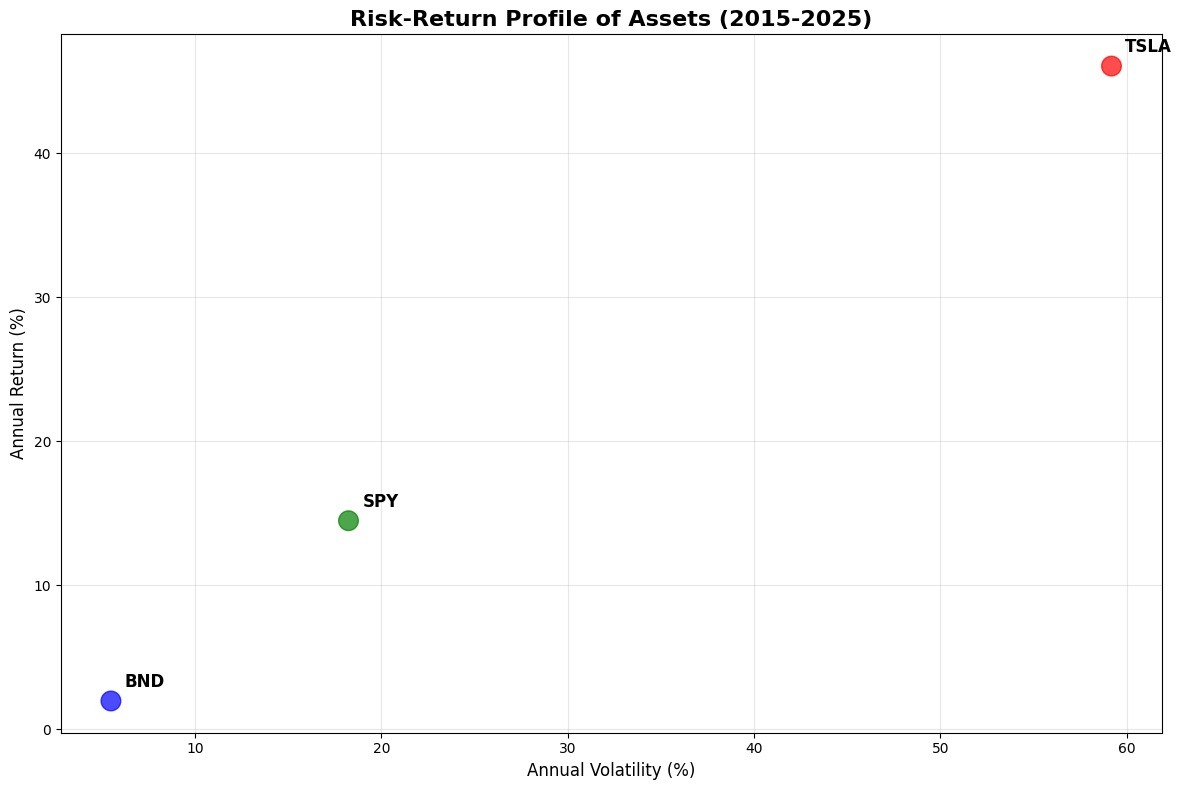

In [8]:

print("\n=== RISK-RETURN VISUALIZATION ===")

# Create summary dataframe
summary_df = pd.DataFrame(sharpe_results).T
summary_df['Daily_VaR_5%'] = [var_results[ticker]['Daily_VaR_5%'] for ticker in summary_df.index]

# Risk-Return scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(summary_df['Annual_Volatility']*100, 
                     summary_df['Annual_Return']*100,
                     s=200, alpha=0.7, c=['red', 'blue', 'green'])

# Add labels
for i, ticker in enumerate(summary_df.index):
    plt.annotate(ticker, 
                (summary_df.loc[ticker, 'Annual_Volatility']*100,
                 summary_df.loc[ticker, 'Annual_Return']*100),
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('Annual Volatility (%)', fontsize=12)
plt.ylabel('Annual Return (%)', fontsize=12)
plt.title('Risk-Return Profile of Assets (2015-2025)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== ROLLING SHARPE RATIO ANALYSIS ===


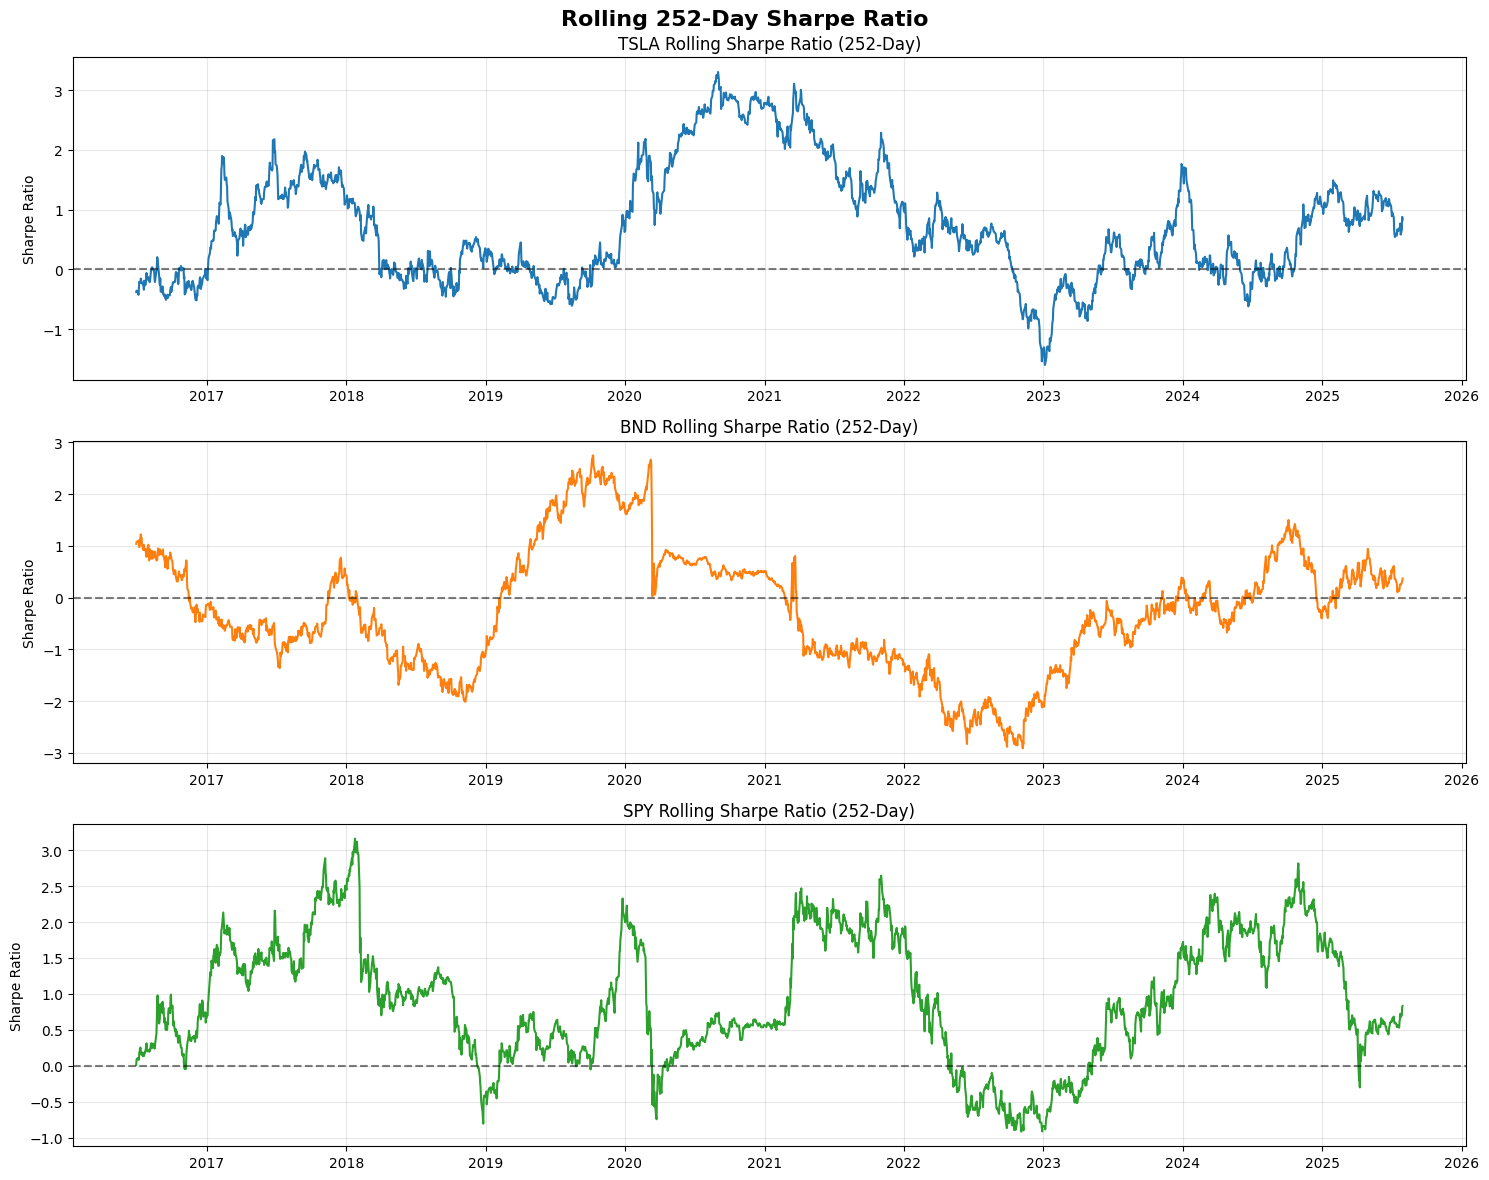

In [9]:
print("=== ROLLING SHARPE RATIO ANALYSIS ===")

fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Rolling 252-Day Sharpe Ratio', fontsize=16, fontweight='bold')

for i, (ticker, data) in enumerate(assets.items()):
    returns = data['Daily_Return'].fillna(0)
    
    # Calculate rolling Sharpe ratio (252-day window)
    rolling_sharpe = []
    for j in range(252, len(returns)):
        window_returns = returns.iloc[j-252:j]
        sharpe = calculate_sharpe_ratio(window_returns) * np.sqrt(252)
        rolling_sharpe.append(sharpe)
    
    # Plot
    dates = returns.index[252:]
    axes[i].plot(dates, rolling_sharpe, linewidth=1.5, color=f'C{i}')
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[i].set_title(f'{ticker} Rolling Sharpe Ratio (252-Day)')
    axes[i].set_ylabel('Sharpe Ratio')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
print("\n=== COMPREHENSIVE RISK METRICS SUMMARY ===")

# Create comprehensive summary
summary_metrics = pd.DataFrame(index=['TSLA', 'BND', 'SPY'])

for ticker in summary_metrics.index:
    returns = assets[ticker]['Daily_Return'].dropna()
    
    summary_metrics.loc[ticker, 'Annual Return (%)'] = returns.mean() * 252 * 100
    summary_metrics.loc[ticker, 'Annual Volatility (%)'] = returns.std() * np.sqrt(252) * 100
    summary_metrics.loc[ticker, 'Sharpe Ratio'] = sharpe_results[ticker]['Sharpe_Ratio']
    summary_metrics.loc[ticker, 'Daily VaR 5% (%)'] = var_results[ticker]['Daily_VaR_5%'] * 100
    summary_metrics.loc[ticker, 'Max Drawdown (%)'] = calculate_max_drawdown(assets[ticker]['Close']) * 100

print(summary_metrics.round(2))


=== COMPREHENSIVE RISK METRICS SUMMARY ===
      Annual Return (%)  Annual Volatility (%)  Sharpe Ratio  \
TSLA              46.07                  59.19          0.73   
BND                1.96                   5.49         -0.19   
SPY               14.48                  18.24          0.63   

      Daily VaR 5% (%)  Max Drawdown (%)  
TSLA              5.47            -73.63  
BND               0.49            -18.58  
SPY               1.72            -33.72  


In [11]:
print("\n=== PERFORMANCE RANKINGS ===")

rankings = pd.DataFrame(index=['TSLA', 'BND', 'SPY'])

# Rank by different metrics (1 = best, 3 = worst)
rankings['Return Rank'] = summary_metrics['Annual Return (%)'].rank(ascending=False)
rankings['Risk Rank'] = summary_metrics['Annual Volatility (%)'].rank(ascending=True)  # Lower risk = better
rankings['Sharpe Rank'] = summary_metrics['Sharpe Ratio'].rank(ascending=False)
rankings['VaR Rank'] = summary_metrics['Daily VaR 5% (%)'].rank(ascending=True)  # Lower VaR = better

# Overall score (lower is better)
rankings['Overall Score'] = rankings.mean(axis=1)
rankings['Overall Rank'] = rankings['Overall Score'].rank()

print("Rankings (1 = Best, 3 = Worst):")
print(rankings.round(1))

print("\n=== KEY INSIGHTS ===")
print("TSLA Characteristics:")
print("- High return potential but very high volatility")
print("- Highest risk as measured by VaR and volatility")
print("- Moderate Sharpe ratio despite high returns")

print("\nBND Characteristics:")
print("- Low volatility and stable returns")
print("- Lowest risk profile among the three assets")
print("- Good for portfolio diversification and risk reduction")

print("\nSPY Characteristics:")
print("- Balanced risk-return profile")
print("- Represents broad market performance")
print("- Good baseline for portfolio construction")

print("\nPortfolio Implications:")
print("- Combining these assets can optimize risk-return trade-off")
print("- TSLA adds growth potential but increases portfolio risk")
print("- BND provides stability and reduces overall portfolio volatility")
print("- SPY offers market-level returns with moderate risk")


=== PERFORMANCE RANKINGS ===
Rankings (1 = Best, 3 = Worst):
      Return Rank  Risk Rank  Sharpe Rank  VaR Rank  Overall Score  \
TSLA          1.0        3.0          1.0       3.0            2.0   
BND           3.0        1.0          3.0       1.0            2.0   
SPY           2.0        2.0          2.0       2.0            2.0   

      Overall Rank  
TSLA           2.0  
BND            2.0  
SPY            2.0  

=== KEY INSIGHTS ===
TSLA Characteristics:
- High return potential but very high volatility
- Highest risk as measured by VaR and volatility
- Moderate Sharpe ratio despite high returns

BND Characteristics:
- Low volatility and stable returns
- Lowest risk profile among the three assets
- Good for portfolio diversification and risk reduction

SPY Characteristics:
- Balanced risk-return profile
- Represents broad market performance
- Good baseline for portfolio construction

Portfolio Implications:
- Combining these assets can optimize risk-return trade-off
- TSLA a